In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [101]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

In [3]:
import cv2
from glob import glob
from skimage.io import imread, imshow
import piexif

In [4]:
import os

In [5]:
# using os sets the \ for me
basepath = os.path.join('..', 'train\\')

In [6]:
print(basepath)

..\train\


In [7]:
all_cervix_images = []

In [8]:
for path in sorted(glob(basepath + "*")):
    # escape \
    cervix_type = path.split("\\")[-1]
    cervix_images = sorted((glob(basepath + cervix_type + "/*")))
    all_cervix_images = all_cervix_images + cervix_images

In [9]:
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("\\")[-2], axis=1)

In [10]:
all_cervix_images.head()

,imagepath,filetype,type
0,..\train\Type_1\0.jpg,jpg,Type_1
1,..\train\Type_1\10.jpg,jpg,Type_1
2,..\train\Type_1\1013.jpg,jpg,Type_1
3,..\train\Type_1\1014.jpg,jpg,Type_1
4,..\train\Type_1\1019.jpg,jpg,Type_1


In [11]:
from scipy import ndimage, misc

In [12]:
print('We have a total of {} images in the whole dataset'.format(all_cervix_images.shape[0]))

We have a total of 1480 images in the whole dataset


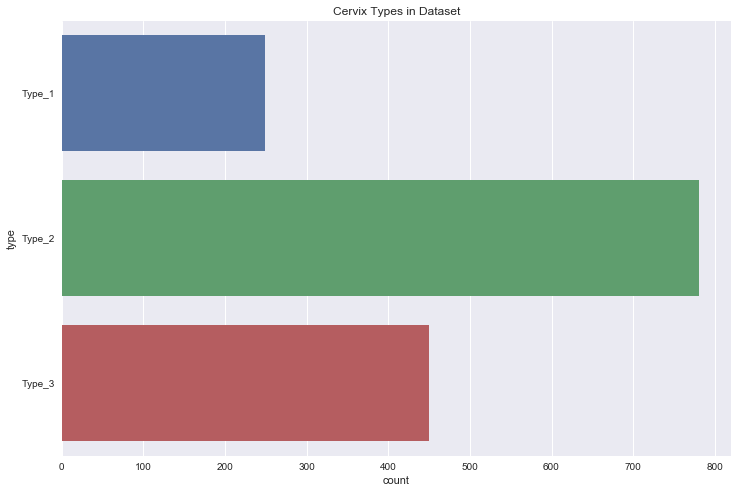

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Cervix Types in Dataset')
sns.countplot(y='type',data=all_cervix_images, ax=ax)

In [14]:
print('Percantage of each type in the data:')
for c_type in ['Type_1', 'Type_2', 'Type_3']:
    print(c_type + ': ' + '{:.1f} %'.format(
        len(all_cervix_images[all_cervix_images.type == c_type]) / len(all_cervix_images) * 100)
         )

Percantage of each type in the data:
Type_1: 16.8 %
Type_2: 52.8 %
Type_3: 30.4 %


In [15]:
# fig = plt.figure(figsize=(12,8))

# i = 1
# for t in all_cervix_images['type'].unique():
#     ax = fig.add_subplot(1,3,i)
#     i+=1
#     f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
#     plt.imshow(plt.imread(f))
#     plt.title('sample for cervix {}'.format(t))

In [16]:
sampled = all_cervix_images.sample(n=200, random_state=42)

In [76]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(sampled['type'])

LabelEncoder()

In [78]:
le.classes_

array(['Type_1', 'Type_2', 'Type_3'], dtype=object)

In [224]:
sampled['l_type'] = le.transform(sampled['type'])

In [225]:
sampled.head()

,imagepath,filetype,type,l_type
661,..\train\Type_2\365.jpg,jpg,Type_2,1
274,..\train\Type_2\1046.jpg,jpg,Type_2,1
394,..\train\Type_2\1233.jpg,jpg,Type_2,1
218,..\train\Type_1\821.jpg,jpg,Type_1,0
922,..\train\Type_2\815.jpg,jpg,Type_2,1


In [226]:
sampled['l_type'].value_counts()

1    106
2     60
0     34
Name: l_type, dtype: int64

In [17]:
dimensions = []

In [18]:
%%time
for i in range(len(sampled)):
    dimensions.append(imread(sampled['imagepath'].iloc[i]).shape)
    if i % 50 == 0:
        print('ok')

ok
ok
ok
ok
Wall time: 2min 37s


In [19]:
from collections import Counter

In [20]:
Counter(dimensions)

Counter({(2448, 3264, 3): 3,
         (3264, 2448, 3): 110,
         (4128, 2322, 3): 2,
         (4128, 3096, 3): 83,
         (4160, 3120, 3): 2})

In [240]:
%%time
images = []
for i in range(len(sampled)):
    image = ndimage.imread(all_cervix_images['imagepath'].iloc[i], mode='RGB')
    image_resized = misc.imresize(image, (28, 28))
    images.append(image_resized)
    if i % 50 == 0:
        print('..', i)

.. 0
.. 50
.. 100
.. 150
Wall time: 3min 9s


In [241]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [253]:
X_train, X_test, y_train, y_test = train_test_split(images, sampled['l_type'], test_size=0.25, random_state=42)

In [254]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [255]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 3)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 3)

In [256]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0

In [257]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train, num_classes=3)
y_test = np_utils.to_categorical(y_test, num_classes=3)
num_classes = y_test.shape[1]

In [258]:
y_test.shape, y_train.shape

((50, 3), (150, 3))

In [259]:
X_test.shape, X_train.shape

((50, 28, 28, 3), (150, 28, 28, 3))

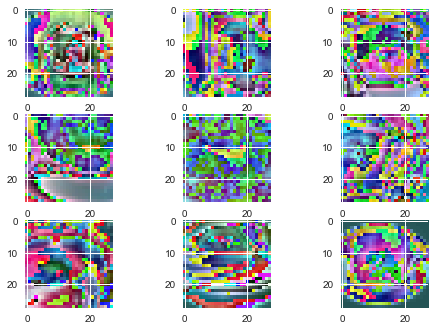

In [260]:
datagen = ImageDataGenerator(featurewise_center=True, 
                             featurewise_std_normalization=True)

datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=10):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
        
    break

In [261]:
# create model
model = Sequential()
    
# convolutional layer, 32 feature maps, size of 5x5 ,rectifier activation, input layer
model.add(Conv2D(32, (3, 3), padding='valid', input_shape=(28, 28, 3),
activation='relu', data_format='channels_last'))
    
# pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
    
# converts 2d matrix data to a vector
model.add(Flatten())
    
# fully connected layer with 128 neurons, rectifier is used
model.add(Dense(64, activation='relu'))
    
# output layer has 3 neurons for the 3 classes, softmax returns probability-like prediction
model.add(Dense(num_classes, activation='softmax'))
    
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [262]:
# Fit the model
# make sure batch size is perfectly divisible
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10,
verbose=2)

Train on 150 samples, validate on 50 samples
Epoch 1/10
1s - loss: 1.0584 - acc: 0.4867 - val_loss: 1.2234 - val_acc: 0.3800
Epoch 2/10
0s - loss: 0.9703 - acc: 0.5800 - val_loss: 1.1549 - val_acc: 0.3800
Epoch 3/10
0s - loss: 0.8989 - acc: 0.5867 - val_loss: 1.2427 - val_acc: 0.3800
Epoch 4/10
0s - loss: 0.8708 - acc: 0.6267 - val_loss: 1.3230 - val_acc: 0.3600
Epoch 5/10
0s - loss: 0.8124 - acc: 0.6467 - val_loss: 1.2556 - val_acc: 0.3400
Epoch 6/10
0s - loss: 0.7706 - acc: 0.6400 - val_loss: 1.2221 - val_acc: 0.3400
Epoch 7/10
0s - loss: 0.7196 - acc: 0.7200 - val_loss: 1.4614 - val_acc: 0.3800
Epoch 8/10
0s - loss: 0.6417 - acc: 0.7200 - val_loss: 1.5298 - val_acc: 0.3800
Epoch 9/10
0s - loss: 0.5958 - acc: 0.7533 - val_loss: 1.6571 - val_acc: 0.3400
Epoch 10/10
0s - loss: 0.5289 - acc: 0.7867 - val_loss: 1.5752 - val_acc: 0.3600
